In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Santa Catarina - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_SC.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - IDH Educacao,Santa Catarina - Consumo de Cimento (t),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.797768,0.311113,0.807065,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,0.852921,0.752747,142.456,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08,11270.272400,8.001967e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.797853,0.312787,0.806745,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,0.853282,0.752954,135.829,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08,11377.902015,8.038182e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.797939,0.314207,0.806425,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,0.853644,0.753161,133.135,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08,11480.211275,8.074397e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.798024,0.315571,0.806105,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,0.854005,0.753368,144.723,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08,11578.298418,8.110613e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.798110,0.316880,0.805786,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,0.854366,0.753575,150.523,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08,11673.320486,8.146828e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42497.575231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42463.822266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42375.031726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42265.885860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


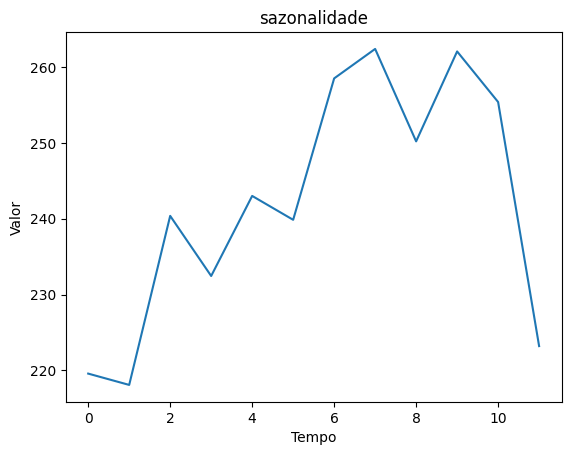

,sazonalidade
sazonalidade,
0,219.591071
1,218.098705
2,240.383349
3,232.458494
4,243.012756
5,239.863999
6,258.505989
7,262.392004
8,250.204324


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - IDH Educacao,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Santa Catarina - Consumo de Cimento (t)
0,2003-1,0.797768,0.311113,0.807065,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,0.852921,0.752747,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08,11270.272400,8.001967e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,219.591071,142.456
1,2003-2,0.797853,0.312787,0.806745,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,0.853282,0.752954,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08,11377.902015,8.038182e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,218.098705,135.829
2,2003-3,0.797939,0.314207,0.806425,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,0.853644,0.753161,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08,11480.211275,8.074397e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,240.383349,133.135
3,2003-4,0.798024,0.315571,0.806105,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,0.854005,0.753368,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08,11578.298418,8.110613e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,232.458494,144.723
4,2003-5,0.798110,0.316880,0.805786,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,0.854366,0.753575,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08,11673.320486,8.146828e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,243.012756,150.523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42497.575231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243.012756,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42463.822266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239.863999,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42375.031726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.505989,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42265.885860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.392004,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      134.837
1      136.495
2      154.807
3      146.582
4      149.537
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Santa Catarina - Consumo de Cimento (t), Length: 249, dtype: float64

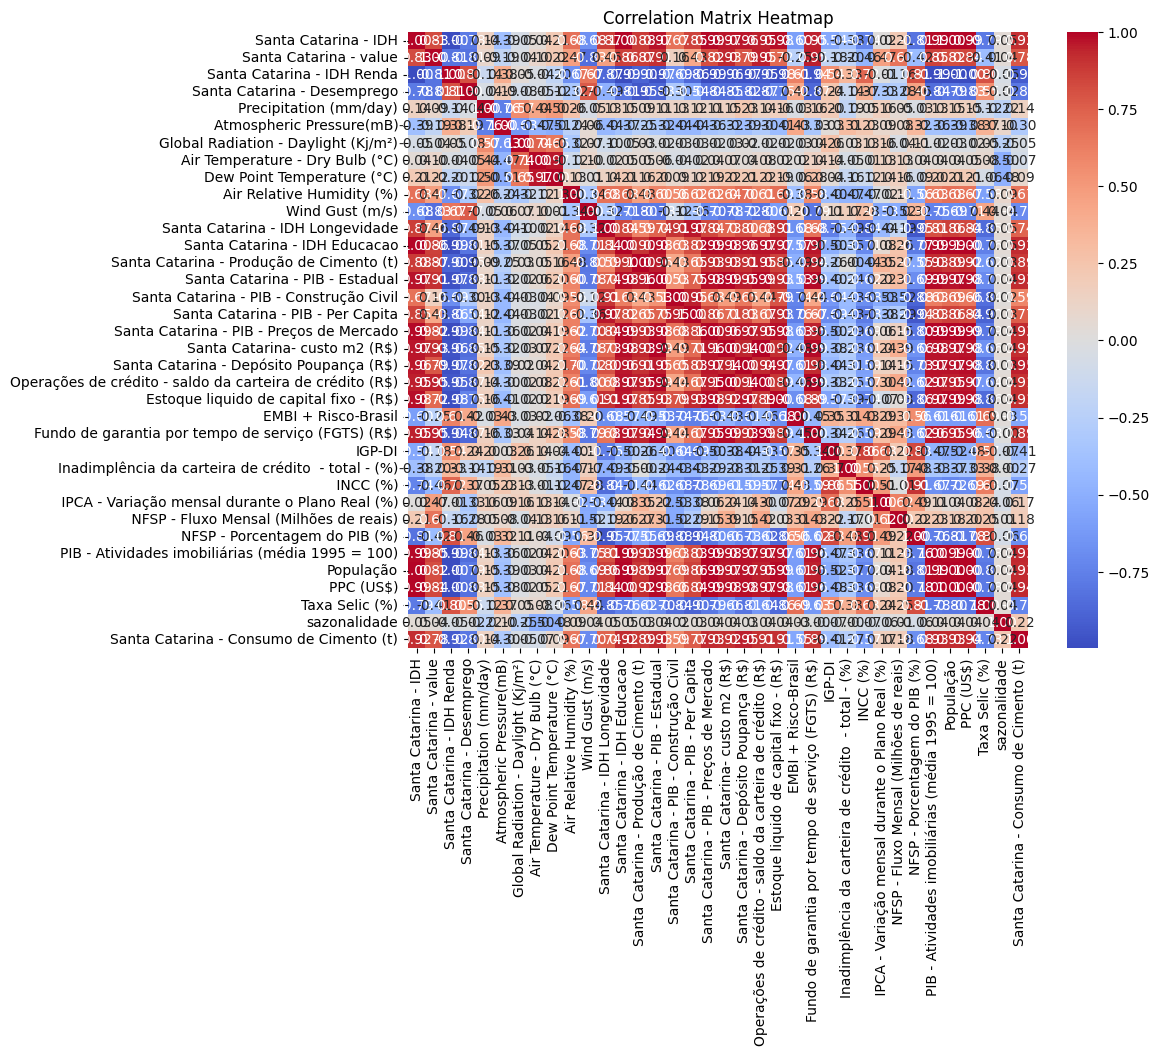

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Santa Catarina - IDH,1.986170e+10
1,Santa Catarina - value,1.094275e+06
2,Santa Catarina - IDH Renda,6.523660e+08
3,Santa Catarina - Desemprego,2.031019e+04
4,Precipitation (mm/day),3.029267e+02
5,Atmospheric Pressure(mB),3.359681e+06
6,Global Radiation - Daylight (Kj/m²),2.655689e+03
7,Air Temperature - Dry Bulb (°C),1.914615e+06
8,Dew Point Temperature (°C),1.290150e+06
9,Air Relative Humidity (%),1.261910e+06


In [39]:
# data = data.drop(['Global Radiation - Daylight (Kj/m²)',
#                  ' IPCA - Variação mensal durante o Plano Real (%)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Temperature - Dry Bulb (°C)',
#                  'Dew Point Temperature (°C)',
#                  'Santa Catarina - Produção de Cimento (t)',
#                  'Santa Catarina- custo m2 (R$)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 10


,Santa Catarina - value,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,0.311113,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,20.216800,11270.272400,8.001967e+06,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,219.591071
1,0.312787,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,19.631031,11377.902015,8.038182e+06,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,218.098705
2,0.314207,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,19.400920,11480.211275,8.074397e+06,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,240.383349
3,0.315571,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,19.153741,11578.298418,8.110613e+06,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,232.458494
4,0.316880,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,18.912155,11673.320486,8.146828e+06,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,243.012756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.498773,5.796374,1.596361,1016.338191,961.401810,20.206984,16.818831,81.757693,1.279914,123.475513,24996.821851,1.781587e+07,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,262.392004
152,0.500224,5.796868,1.635391,1015.301101,955.922193,20.749104,17.349966,81.714792,1.520067,123.228194,25136.832647,1.774829e+07,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,250.204324
153,0.501838,5.797362,1.685499,1014.687434,1013.621205,21.728863,18.063880,80.583726,1.764929,122.563979,25274.288407,1.768072e+07,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,262.060571
154,0.503621,5.797856,1.789531,1013.812416,1099.658039,22.869644,18.945780,79.511432,1.827820,122.091545,25413.902871,1.761314e+07,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,255.391914


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.880037,-0.244426,0.686773,0.028839,-0.216033,-0.385111,-0.738363,0.776503,-0.946572,-1.464972,-1.450441,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,0.875368,-0.243185,0.683314,0.028710,-0.215302,-0.383606,-0.734904,0.776503,-0.958527,-1.438840,-1.441525,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,0.870699,-0.242461,0.681296,0.028634,-0.214876,-0.382728,-0.732887,0.776503,-0.963224,-1.413999,-1.432610,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,0.866031,-0.242384,0.681079,0.028626,-0.214831,-0.382634,-0.732670,0.776503,-0.968268,-1.390184,-1.423695,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,0.861362,0.135988,0.432420,0.356695,0.092361,-0.087332,-0.778136,0.769871,-0.973199,-1.367112,-1.414779,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,-1.075117,-0.320013,-0.069366,-1.560254,-0.494802,0.004703,1.895167,-1.036872,1.160908,1.867844,0.965524,1.823582,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.398025,0.209123
152,-1.074724,-0.236048,-0.392379,-1.602163,-0.196338,0.306487,1.876306,-0.619478,1.155860,1.901839,0.948888,1.841017,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.415152,-0.182135
153,-1.074332,-0.128253,-0.583513,-1.160875,0.343067,0.712123,1.379067,-0.193897,1.142304,1.935213,0.932252,1.860456,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.432633,0.413308
154,-1.073939,0.095547,-0.856046,-0.502857,0.971123,1.213205,0.907665,-0.084591,1.132662,1.969112,0.915617,1.876950,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.450965,0.074029


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.880037,-0.244426,0.686773,0.028839,-0.216033,-0.385111,-0.738363,0.776503,-0.946572,-1.464972,-1.450441,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,0.875368,-0.243185,0.683314,0.028710,-0.215302,-0.383606,-0.734904,0.776503,-0.958527,-1.438840,-1.441525,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,0.870699,-0.242461,0.681296,0.028634,-0.214876,-0.382728,-0.732887,0.776503,-0.963224,-1.413999,-1.432610,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,0.866031,-0.242384,0.681079,0.028626,-0.214831,-0.382634,-0.732670,0.776503,-0.968268,-1.390184,-1.423695,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,0.861362,0.135988,0.432420,0.356695,0.092361,-0.087332,-0.778136,0.769871,-0.973199,-1.367112,-1.414779,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-1.170952,0.243580,0.227604,-0.044438,-0.490316,-0.436177,0.313025,-1.606960,1.338578,1.451886,1.202857,1.517172,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.245801,-0.282621
140,-1.152334,0.210108,-0.105608,0.366733,0.073060,0.125377,0.258672,-1.439440,1.319309,1.485579,1.178681,1.549848,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.254608,-0.612121
141,-1.133717,0.534346,-0.350752,1.251435,0.724836,0.637405,-0.242966,-1.386062,1.299440,1.520154,1.154504,1.588878,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.263636,-0.137902
142,-1.115100,0.783509,-0.675888,1.456770,1.208765,1.162860,-0.102448,-1.398844,1.278984,1.554902,1.130327,1.625721,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.272935,-0.332143


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      134.837000
1      136.495000
2      154.807000
3      146.582000
4      149.537000
          ...    
139    261.447551
140    250.945126
141    261.161947
142    255.415401
143    232.031000
Name: Santa Catarina - Consumo de Cimento (t), Length: 144, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 23)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,-1.898536,0.705531,-0.881705,1.613897,1.091772,0.988243,-0.354563,-0.191986,1.125184,0.623858,0.776786,0.595959,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.812014,-1.082183
109,-1.870222,0.292994,-0.637172,1.358580,0.919784,0.833424,-0.275396,-0.415486,1.170592,0.648736,0.818922,0.621380,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.831569,-1.036767
110,-1.841907,0.422224,-0.350368,0.639178,0.318850,0.267816,-0.118152,-0.516693,1.205543,0.674130,0.861059,0.652999,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.850791,-0.752482
111,-1.813593,-0.156155,-0.069377,-0.373580,-0.406378,-0.333976,0.329918,-0.600317,1.234447,0.699550,0.903195,0.685630,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.868783,-1.088413
112,-1.785278,-0.315107,0.399911,-0.674891,-0.856089,-0.693556,0.677531,-0.546059,1.265040,0.724964,0.945332,0.717515,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.886720,-1.508135
113,-1.756964,-0.571360,0.534406,-0.834863,-1.147375,-1.026927,0.539059,-0.346178,1.282011,0.752872,0.987468,0.747579,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.905151,-1.474280
114,-1.728649,-0.865848,0.488186,-0.842571,-1.046983,-0.911583,0.579411,-0.213723,1.303409,0.775209,1.029605,0.775262,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.923702,-1.463452
115,-1.700335,-0.846674,0.343741,-0.095195,-0.603141,-0.539264,0.292513,0.001346,1.326543,0.796246,1.071741,0.805205,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.942382,-1.236037
116,-1.672020,-0.855474,-0.212747,0.317205,-0.047751,-0.087613,-0.102702,0.151748,1.336644,0.817340,1.113878,0.836796,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.960385,-0.935721
117,-1.643706,-0.761438,-0.544915,0.789118,0.500873,0.409917,-0.313901,0.069790,1.345579,0.838738,1.156014,0.876422,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.977769,-1.241995


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 23)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1722640353, 2537920202, 4130113591, 3286045441, 1721391587, 834876352, 1093491710, 3447674764, 2924297609, 3929674153]


Step: 0 ___________________________________________
val_loss: 249.91070556640625
winner_seed: 1722640353


Step: 1 ___________________________________________
val_loss: 150.42579650878906
winner_seed: 2537920202


Step: 2 ___________________________________________
val_loss: 177.5378875732422


Step: 3 ___________________________________________
val_loss: 348226.15625


Step: 4 ___________________________________________
val_loss: 513787.0


Step: 5 ___________________________________________
val_loss: 688.4415283203125


Step: 6 ___________________________________________
val_loss: 214.11927795410156


Step: 7 ___________________________________________
val_loss: 362.1837463378906


Step: 8 ___________________________________________
val_loss: 682.7312622070312


Step: 9 ___________________________________________
val_loss: 1402.3272705078125


final_seed: 25379202

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 3s 328ms/step - loss: 62235.6250 - val_loss: 156.6065
Epoch 2/10000
4/4 [==============================] - 0s 12ms/step - loss: 1332.9762 - val_loss: 460.1394
Epoch 3/10000
4/4 [==============================] - 0s 13ms/step - loss: 1247.5013 - val_loss: 264.5660
Epoch 4/10000
4/4 [==============================] - 0s 13ms/step - loss: 1605.3817 - val_loss: 365.3091
Epoch 5/10000
4/4 [==============================] - 0s 13ms/step - loss: 1278.6705 - val_loss: 448.5705
Epoch 6/10000
4/4 [==============================] - 0s 12ms/step - loss: 1071.1423 - val_loss: 181.7390
Epoch 7/10000
4/4 [==============================] - 0s 13ms/step - loss: 1230.9353 - val_loss: 287.4720
Epoch 8/10000
4/4 [==============================] - 0s 12ms/step - loss: 1003.3712 - val_loss: 1293.0195
Epoch 9/10000
4/4 [==============================] - 0s 13ms/step - loss: 986.5106 - val_loss: 3501.0413
Epoch 10/10000
4/4 [==============================] 

4/4 [==============================] - 0s 14ms/step - loss: 550.0247 - val_loss: 4114.0435
Epoch 79/10000
4/4 [==============================] - 0s 13ms/step - loss: 705.8643 - val_loss: 1468.6654
Epoch 80/10000
4/4 [==============================] - 0s 12ms/step - loss: 688.1736 - val_loss: 2649.7219
Epoch 81/10000
4/4 [==============================] - 0s 12ms/step - loss: 650.2529 - val_loss: 1268.3743
Epoch 82/10000
4/4 [==============================] - 0s 13ms/step - loss: 563.1175 - val_loss: 556.4197
Epoch 83/10000
4/4 [==============================] - 0s 13ms/step - loss: 713.5198 - val_loss: 2422.3372
Epoch 84/10000
4/4 [==============================] - 0s 13ms/step - loss: 657.7352 - val_loss: 2389.5059
Epoch 85/10000
4/4 [==============================] - 0s 12ms/step - loss: 698.6240 - val_loss: 3997.9126
Epoch 86/10000
4/4 [==============================] - 0s 13ms/step - loss: 877.3643 - val_loss: 630.1055
Epoch 87/10000
4/4 [==============================] - 0s 12ms/s

4/4 [==============================] - 0s 13ms/step - loss: 681.0438 - val_loss: 3079.4187
Epoch 156/10000
4/4 [==============================] - 0s 14ms/step - loss: 706.4045 - val_loss: 1198.3416
Epoch 157/10000
4/4 [==============================] - 0s 12ms/step - loss: 602.6044 - val_loss: 2839.2219
Epoch 158/10000
4/4 [==============================] - 0s 12ms/step - loss: 726.3510 - val_loss: 2614.5972
Epoch 159/10000
4/4 [==============================] - 0s 13ms/step - loss: 592.2986 - val_loss: 1717.9581
Epoch 160/10000
4/4 [==============================] - 0s 12ms/step - loss: 607.2543 - val_loss: 2642.8022
Epoch 161/10000
4/4 [==============================] - 0s 12ms/step - loss: 647.6514 - val_loss: 3374.6680
Epoch 162/10000
4/4 [==============================] - 0s 12ms/step - loss: 663.5648 - val_loss: 1731.7355
Epoch 163/10000
4/4 [==============================] - 0s 13ms/step - loss: 537.9803 - val_loss: 1910.8751
Epoch 164/10000
4/4 [==============================] 

4/4 [==============================] - 0s 13ms/step - loss: 688.2888 - val_loss: 970.1790
Epoch 233/10000
4/4 [==============================] - 0s 13ms/step - loss: 575.2581 - val_loss: 1074.5554
Epoch 234/10000
4/4 [==============================] - 0s 12ms/step - loss: 590.0399 - val_loss: 187.6887
Epoch 235/10000
4/4 [==============================] - 0s 13ms/step - loss: 1047.3594 - val_loss: 1272.4817
Epoch 236/10000
4/4 [==============================] - 0s 19ms/step - loss: 716.8491 - val_loss: 308.7474
Epoch 237/10000
4/4 [==============================] - 0s 13ms/step - loss: 795.4866 - val_loss: 835.2397
Epoch 238/10000
4/4 [==============================] - 0s 12ms/step - loss: 650.9410 - val_loss: 1027.2246
Epoch 239/10000
4/4 [==============================] - 0s 12ms/step - loss: 650.7084 - val_loss: 981.8943
Epoch 240/10000
4/4 [==============================] - 0s 12ms/step - loss: 640.8370 - val_loss: 1648.9565
Epoch 241/10000
4/4 [==============================] - 0s

4/4 [==============================] - 0s 14ms/step - loss: 437.1637 - val_loss: 1267.8206
Epoch 310/10000
4/4 [==============================] - 0s 13ms/step - loss: 451.1349 - val_loss: 247.5402
Epoch 311/10000
4/4 [==============================] - 0s 13ms/step - loss: 593.6862 - val_loss: 550.3153
Epoch 312/10000
4/4 [==============================] - 0s 13ms/step - loss: 447.5739 - val_loss: 1240.7837
Epoch 313/10000
4/4 [==============================] - 0s 13ms/step - loss: 431.3169 - val_loss: 196.7058
Epoch 314/10000
4/4 [==============================] - 0s 13ms/step - loss: 699.8690 - val_loss: 222.9898
Epoch 315/10000
4/4 [==============================] - 0s 12ms/step - loss: 642.2400 - val_loss: 785.0293
Epoch 316/10000
4/4 [==============================] - 0s 13ms/step - loss: 487.7238 - val_loss: 1020.1357
Epoch 317/10000
4/4 [==============================] - 0s 12ms/step - loss: 416.5850 - val_loss: 1180.9301
Epoch 318/10000
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 13ms/step - loss: 559.3040 - val_loss: 504.3468
Epoch 387/10000
4/4 [==============================] - 0s 13ms/step - loss: 613.0567 - val_loss: 615.9485
Epoch 388/10000
4/4 [==============================] - 0s 13ms/step - loss: 541.0703 - val_loss: 2303.9456
Epoch 389/10000
4/4 [==============================] - 0s 12ms/step - loss: 541.3911 - val_loss: 789.5634
Epoch 390/10000
4/4 [==============================] - 0s 13ms/step - loss: 480.5620 - val_loss: 231.2464
Epoch 391/10000
4/4 [==============================] - 0s 11ms/step - loss: 684.7450 - val_loss: 443.8521
Epoch 392/10000
4/4 [==============================] - 0s 13ms/step - loss: 479.3606 - val_loss: 1547.3457
Epoch 393/10000
4/4 [==============================] - 0s 13ms/step - loss: 447.9429 - val_loss: 458.5277
Epoch 394/10000
4/4 [==============================] - 0s 12ms/step - loss: 536.4558 - val_loss: 1625.6863
Epoch 395/10000
4/4 [==============================] - 0s 1

Epoch 463/10000
4/4 [==============================] - 0s 15ms/step - loss: 457.9561 - val_loss: 1162.0128
Epoch 464/10000
4/4 [==============================] - 0s 13ms/step - loss: 490.5319 - val_loss: 1317.6874
Epoch 465/10000
4/4 [==============================] - 0s 13ms/step - loss: 497.8567 - val_loss: 1191.4862
Epoch 466/10000
4/4 [==============================] - 0s 13ms/step - loss: 513.5068 - val_loss: 1349.9430
Epoch 467/10000
4/4 [==============================] - 0s 12ms/step - loss: 478.2682 - val_loss: 2209.5017
Epoch 468/10000
4/4 [==============================] - 0s 13ms/step - loss: 472.8571 - val_loss: 1544.2144
Epoch 469/10000
4/4 [==============================] - 0s 12ms/step - loss: 434.9989 - val_loss: 2662.1140
Epoch 470/10000
4/4 [==============================] - 0s 13ms/step - loss: 488.5055 - val_loss: 1849.7189
Epoch 471/10000
4/4 [==============================] - 0s 12ms/step - loss: 410.5095 - val_loss: 749.5740
Epoch 472/10000
4/4 [=================

Epoch 540/10000
4/4 [==============================] - 0s 13ms/step - loss: 416.0121 - val_loss: 1375.4609
Epoch 541/10000
4/4 [==============================] - 0s 13ms/step - loss: 407.4135 - val_loss: 1954.5458
Epoch 542/10000
4/4 [==============================] - 0s 13ms/step - loss: 438.0004 - val_loss: 1606.3707
Epoch 543/10000
4/4 [==============================] - 0s 12ms/step - loss: 413.8816 - val_loss: 534.0268
Epoch 544/10000
4/4 [==============================] - 0s 13ms/step - loss: 439.6406 - val_loss: 1512.2316
Epoch 545/10000
4/4 [==============================] - 0s 14ms/step - loss: 436.8396 - val_loss: 1556.0050
Epoch 546/10000
4/4 [==============================] - 0s 14ms/step - loss: 488.0562 - val_loss: 953.8072
Epoch 547/10000
4/4 [==============================] - 0s 13ms/step - loss: 419.6813 - val_loss: 1043.6472
Epoch 548/10000
4/4 [==============================] - 0s 12ms/step - loss: 615.9554 - val_loss: 478.7346
Epoch 549/10000
4/4 [===================

Epoch 617/10000
4/4 [==============================] - 0s 11ms/step - loss: 535.0646 - val_loss: 2162.6284
Epoch 618/10000
4/4 [==============================] - 0s 11ms/step - loss: 525.4221 - val_loss: 1796.4550
Epoch 619/10000
4/4 [==============================] - 0s 10ms/step - loss: 516.8104 - val_loss: 1937.5554
Epoch 620/10000
4/4 [==============================] - 0s 10ms/step - loss: 549.7294 - val_loss: 1793.2515
Epoch 621/10000
4/4 [==============================] - 0s 11ms/step - loss: 555.7364 - val_loss: 757.1726
Epoch 622/10000
4/4 [==============================] - 0s 11ms/step - loss: 580.1930 - val_loss: 2525.5288
Epoch 623/10000
4/4 [==============================] - 0s 12ms/step - loss: 688.6959 - val_loss: 1086.7347
Epoch 624/10000
4/4 [==============================] - 0s 12ms/step - loss: 550.5987 - val_loss: 321.0861
Epoch 625/10000
4/4 [==============================] - 0s 12ms/step - loss: 595.1638 - val_loss: 2041.6344
Epoch 626/10000
4/4 [==================

4/4 [==============================] - 0s 12ms/step - loss: 498.3061 - val_loss: 357.5920
Epoch 695/10000
4/4 [==============================] - 0s 12ms/step - loss: 508.4668 - val_loss: 1080.5811
Epoch 696/10000
4/4 [==============================] - 0s 13ms/step - loss: 464.6556 - val_loss: 1181.3794
Epoch 697/10000
4/4 [==============================] - 0s 12ms/step - loss: 459.8813 - val_loss: 837.8043
Epoch 698/10000
4/4 [==============================] - 0s 13ms/step - loss: 414.9279 - val_loss: 1076.3691
Epoch 699/10000
4/4 [==============================] - 0s 13ms/step - loss: 416.0650 - val_loss: 715.2976
Epoch 700/10000
4/4 [==============================] - 0s 12ms/step - loss: 415.3448 - val_loss: 996.6772
Epoch 701/10000
4/4 [==============================] - 0s 13ms/step - loss: 455.8901 - val_loss: 550.6204
Epoch 702/10000
4/4 [==============================] - 0s 13ms/step - loss: 416.3580 - val_loss: 513.9622
Epoch 703/10000
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 11ms/step - loss: 465.5501 - val_loss: 318.4289
Epoch 772/10000
4/4 [==============================] - 0s 10ms/step - loss: 490.4059 - val_loss: 677.1045
Epoch 773/10000
4/4 [==============================] - 0s 11ms/step - loss: 440.7456 - val_loss: 865.4568
Epoch 774/10000
4/4 [==============================] - 0s 11ms/step - loss: 476.5589 - val_loss: 548.4785
Epoch 775/10000
4/4 [==============================] - 0s 10ms/step - loss: 392.5865 - val_loss: 385.9288
Epoch 776/10000
4/4 [==============================] - 0s 11ms/step - loss: 401.5026 - val_loss: 470.6101
Epoch 777/10000
4/4 [==============================] - 0s 11ms/step - loss: 503.1245 - val_loss: 656.6145
Epoch 778/10000
4/4 [==============================] - 0s 11ms/step - loss: 447.4344 - val_loss: 478.0357
Epoch 779/10000
4/4 [==============================] - 0s 12ms/step - loss: 429.6685 - val_loss: 246.0039
Epoch 780/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 12ms/step - loss: 608.4191 - val_loss: 2444.6924
Epoch 849/10000
4/4 [==============================] - 0s 12ms/step - loss: 526.8629 - val_loss: 2135.3359
Epoch 850/10000
4/4 [==============================] - 0s 12ms/step - loss: 538.6663 - val_loss: 2423.9727
Epoch 851/10000
4/4 [==============================] - 0s 13ms/step - loss: 512.9294 - val_loss: 3385.2971
Epoch 852/10000
4/4 [==============================] - 0s 14ms/step - loss: 534.4456 - val_loss: 2852.4243
Epoch 853/10000
4/4 [==============================] - 0s 13ms/step - loss: 497.9681 - val_loss: 1574.2247
Epoch 854/10000
4/4 [==============================] - 0s 12ms/step - loss: 469.2770 - val_loss: 1875.0160
Epoch 855/10000
4/4 [==============================] - 0s 13ms/step - loss: 519.7899 - val_loss: 2240.5002
Epoch 856/10000
4/4 [==============================] - 0s 13ms/step - loss: 567.0599 - val_loss: 1450.3118
Epoch 857/10000
4/4 [==============================] 

4/4 [==============================] - 0s 12ms/step - loss: 365.0020 - val_loss: 981.5491
Epoch 926/10000
4/4 [==============================] - 0s 13ms/step - loss: 470.8939 - val_loss: 747.9756
Epoch 927/10000
4/4 [==============================] - 0s 12ms/step - loss: 455.1651 - val_loss: 927.0081
Epoch 928/10000
4/4 [==============================] - 0s 13ms/step - loss: 481.2300 - val_loss: 829.8166
Epoch 929/10000
4/4 [==============================] - 0s 13ms/step - loss: 465.9609 - val_loss: 449.1753
Epoch 930/10000
4/4 [==============================] - 0s 13ms/step - loss: 436.7230 - val_loss: 764.6309
Epoch 931/10000
4/4 [==============================] - 0s 14ms/step - loss: 471.5348 - val_loss: 869.9714
Epoch 932/10000
4/4 [==============================] - 0s 13ms/step - loss: 447.1891 - val_loss: 671.1980
Epoch 933/10000
4/4 [==============================] - 0s 13ms/step - loss: 434.9084 - val_loss: 603.9218
Epoch 934/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 13ms/step - loss: 485.2657 - val_loss: 565.7861
Epoch 1003/10000
4/4 [==============================] - 0s 12ms/step - loss: 467.0683 - val_loss: 383.5895
Epoch 1004/10000
4/4 [==============================] - 0s 14ms/step - loss: 418.4293 - val_loss: 819.6138
Epoch 1005/10000
4/4 [==============================] - 0s 13ms/step - loss: 441.6920 - val_loss: 242.2809
Epoch 1006/10000
4/4 [==============================] - 0s 13ms/step - loss: 870.1594 - val_loss: 281.0485
Epoch 1007/10000
4/4 [==============================] - 0s 12ms/step - loss: 729.3626 - val_loss: 679.2307
Epoch 1008/10000
4/4 [==============================] - 0s 13ms/step - loss: 593.6448 - val_loss: 1187.5861
Epoch 1009/10000
4/4 [==============================] - 0s 13ms/step - loss: 529.3317 - val_loss: 758.3053
Epoch 1010/10000
4/4 [==============================] - 0s 13ms/step - loss: 572.1401 - val_loss: 900.0060
Epoch 1011/10000
4/4 [==============================]

4/4 [==============================] - 0s 13ms/step - loss: 510.2971 - val_loss: 1239.4767
Epoch 1079/10000
4/4 [==============================] - 0s 12ms/step - loss: 471.8844 - val_loss: 695.6664
Epoch 1080/10000
4/4 [==============================] - 0s 12ms/step - loss: 459.2273 - val_loss: 1303.2660
Epoch 1081/10000
4/4 [==============================] - 0s 12ms/step - loss: 457.7352 - val_loss: 1352.3090
Epoch 1082/10000
4/4 [==============================] - 0s 12ms/step - loss: 430.6648 - val_loss: 678.9852
Epoch 1083/10000
4/4 [==============================] - 0s 13ms/step - loss: 598.3909 - val_loss: 870.1935
Epoch 1084/10000
4/4 [==============================] - 0s 13ms/step - loss: 622.8439 - val_loss: 1360.9209
Epoch 1085/10000
4/4 [==============================] - 0s 13ms/step - loss: 533.7044 - val_loss: 1506.7827
Epoch 1086/10000
4/4 [==============================] - 0s 11ms/step - loss: 568.6150 - val_loss: 1092.9346
Epoch 1087/10000
4/4 [==========================

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,248.890259,248.839096,248.886292,248.772064,244.486481,238.98584,241.270294,245.639526,244.386276,236.511597,241.42981,248.058746
Target,220.479,211.861,258.76,211.393,249.531,231.359,265.999,277.169,245.824,244.227,263.751,211.136
Error,28.411255,36.978104,9.873718,37.379059,5.044525,7.626846,24.728699,31.52948,1.437729,7.715408,22.321198,36.922745


In [54]:
display(mae)
display(mape)

20.83073

0.08960248

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-11: |Prediction[[2936.156]] - Target[2891.489]| =  Error: [[44.666992]]; MAPE:[[0.01544775]]


[array([[44.666992]], dtype=float32)]

44.666992

0.015447748